This **notebook** is meant to create a `neural network` model and compare it to the `improved baseline` model **results**.  
Neural network models obtained a `81% accuracy` on the test set, which is a major improvement compared to baseline model, but still not much (compared to `90% precision` for improved model)

***Import necessary libraries***

In [72]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

In [73]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Import the data

As always, we import the data.

In [74]:
# import the preprocessed vectorized data
train_data = pd.read_csv('data/pre_proc_data/train.txt')
test_data = pd.read_csv('data/pre_proc_data/test.txt')
val_data = pd.read_csv('data/pre_proc_data/val.txt')

<a id="section-two"></a>
# Neural Network Model

## Prepare the data

Lets start by tokenizing the data, pad the sequences and convert the classes to numeric values.

In [75]:
texts = train_data["text"].tolist()
labels = train_data["emotion"].tolist()

# we tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [76]:
sequences = tokenizer.texts_to_sequences(texts)
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [77]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

Now we need to **encode** the texts.  
`One hot encoding` works fine for our needs (see [here](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)).

In [78]:
# one-hot encode the labels
one_hot_labels = keras.utils.to_categorical(labels)

In [79]:
# now we can split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(padded_sequences, one_hot_labels, test_size=0.2)

Check for the shapes of the data.

In [80]:
print("xtest shape:", xtest.shape)
print("ytest shape:", ytest.shape)

xtest shape: (3200, 66)
ytest shape: (3200, 6)


## Create the model

We will use a `sequential` model with `embedding`, `Flatten` and `Dense` layers.  Finishing with a `softmax` activation function.  
We will use `categorical_crossentropy` as the `loss` function and `accuracy` as the `metric`.  

This is based on the [Keras documentation](https://keras.io/examples/pretrained_word_embeddings/).  
Also there are some good examples [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/).  
And also on [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/code).  

For most of what I saw those were the layers used.  I tried to add more layers but the results were not better.

In [81]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=len(one_hot_labels[0]), activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(xtrain, ytrain, epochs=15, batch_size=32, validation_data=(xtest, ytest))

Epoch 1/15
400/400 [==============================] - 28s 64ms/step - loss: 1.4062 - accuracy: 0.4580 - val_loss: 0.9728 - val_accuracy: 0.6534
Epoch 2/15
400/400 [==============================] - 24s 59ms/step - loss: 0.4423 - accuracy: 0.8573 - val_loss: 0.5021 - val_accuracy: 0.8356
Epoch 3/15
400/400 [==============================] - 24s 59ms/step - loss: 0.0795 - accuracy: 0.9787 - val_loss: 0.5223 - val_accuracy: 0.8297
Epoch 4/15
400/400 [==============================] - 26s 65ms/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.5739 - val_accuracy: 0.8309
Epoch 5/15
400/400 [==============================] - 24s 60ms/step - loss: 0.0217 - accuracy: 0.9955 - val_loss: 0.5464 - val_accuracy: 0.8419
Epoch 6/15
400/400 [==============================] - 24s 60ms/step - loss: 0.0160 - accuracy: 0.9966 - val_loss: 0.5740 - val_accuracy: 0.8400
Epoch 7/15
400/400 [==============================] - 23s 58ms/step - loss: 0.0163 - accuracy: 0.9965 - val_loss: 0.5919 - val_accuracy:

It took 6mn14 to run, lets analyze the curves and results.

In [84]:
history = model.fit(xtrain, ytrain, epochs=5, batch_size=32, validation_data=(xtest, ytest))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

Epoch 1/5
 20/400 [>.............................] - ETA: 35s - loss: 0.0256 - accuracy: 0.9891

400/400 [==============================] - 29s 71ms/step - loss: 0.0259 - accuracy: 0.9913 - val_loss: 1.0513 - val_accuracy: 0.8097
Epoch 2/5
400/400 [==============================] - 26s 66ms/step - loss: 0.0083 - accuracy: 0.9960 - val_loss: 1.0289 - val_accuracy: 0.8166
Epoch 3/5
400/400 [==============================] - 28s 70ms/step - loss: 0.0051 - accuracy: 0.9974 - val_loss: 1.0714 - val_accuracy: 0.8169
Epoch 4/5
400/400 [==============================] - 24s 59ms/step - loss: 0.0042 - accuracy: 0.9973 - val_loss: 1.1065 - val_accuracy: 0.8219
Epoch 5/5
400/400 [==============================] - 25s 62ms/step - loss: 0.0043 - accuracy: 0.9974 - val_loss: 1.0529 - val_accuracy: 0.8156


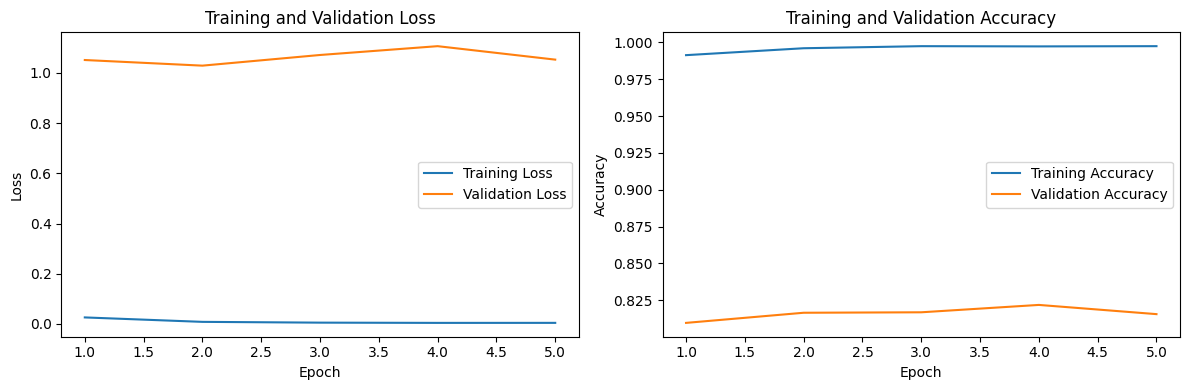

In [85]:
# plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Looking at the curves, we can see that the `loss` is decreasing and the `accuracy` is increasing as expected, they are a bit flat, which indicates that we could train the model a bit more, but 7mn is already a lot.

Now lets see the accuracy.

In [86]:
loss, accuracy = model.evaluate(xtrain, ytrain, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(xtest, ytest, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9981
Testing Accuracy:  0.8156


Results were :
```bash
Training Accuracy: 0.9984
Testing Accuracy:  0.8166
```

Accuracy is good, but not as good as the `improved baseline` model.  
In fact it's a bit low for a `neural network` model.  
This can be due to the fact that we have a small dataset and that we are using `one hot encoding`, one improvement could be to use `word embeddings` instead and see if the results are better.

For now we can save the architecture of the model and the weights.

In [87]:
model_architecture = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_architecture)

model.save_weights("model_weights.h5")

Now given a sentence, we can predict the emotion.  
Lets try with "I'm glade I'm in vacation working NPL project !".

In [88]:
input_text = "I'm glade I'm in vacation working NPL project !"

# Preprocess the input text
input_sequence = tokenizer.texts_to_sequences([input_text])
padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length)
prediction = model.predict(padded_input_sequence)
predicted_label = label_encoder.inverse_transform([np.argmax(prediction[0])])
print(predicted_label)

1/1 [==============================] - 0s 437ms/step
['joy']


Good so it worked pretty well !